In [1]:
import pandas_datareader as pdr
import pandas as pd

In [3]:
import yfinance as yf

df = yf.download('AAPL', start='2015-01-01', end='2024-01-01')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320431,24.789800,23.879980,24.778677,212818400
2015-01-05,23.635286,24.169166,23.448429,24.089084,257142000
2015-01-06,23.637516,23.897782,23.274922,23.699802,263188400
2015-01-07,23.968956,24.069058,23.735383,23.846608,160423600
2015-01-08,24.889904,24.947741,24.180289,24.298189,237458000


In [4]:
df1=df.reset_index()['Close']

In [5]:
df1

Ticker,AAPL
0,24.320431
1,23.635286
2,23.637516
3,23.968956
4,24.889904
...,...
2259,192.444595
2260,191.897873
2261,191.997269
2262,192.424713


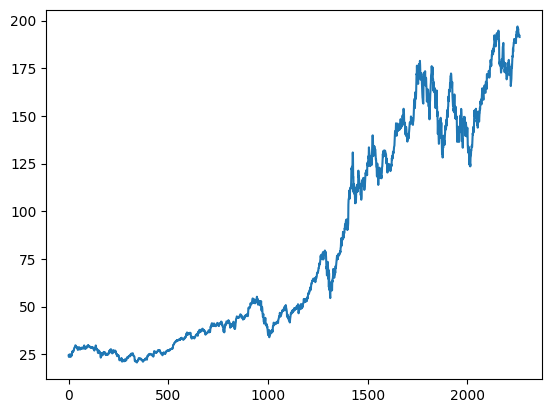

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [8]:
import numpy as np

In [9]:
df1

Ticker,AAPL
0,24.320431
1,23.635286
2,23.637516
3,23.968956
4,24.889904
...,...
2259,192.444595
2260,191.897873
2261,191.997269
2262,192.424713


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
print(df1)

[[0.02068559]
 [0.01679832]
 [0.01681097]
 ...
 [0.97202657]
 [0.97445175]
 [0.96852988]]


In [12]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(1471, 793)

In [14]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)

(1370, 100)
(1370,)


(None, None)

In [17]:
print(X_test.shape), print(ytest.shape)

(692, 100)
(692,)


(None, None)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - loss: 0.0153 - val_loss: 0.0107
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 3.9698e-04 - val_loss: 0.0020
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - loss: 2.9333e-04 - val_loss: 0.0018
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 3.4128e-04 - val_loss: 0.0024
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - loss: 3.1956e-04 - val_loss: 0.0033
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 3.1388e-04 - val_loss: 0.0033
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 2.6423e-04 - val_loss: 0.0044
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 2.8897e-04 - val_loss: 0.0039
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 2.5674e-04 - val_loss: 0.0024
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 2.4064e-04 - val_loss: 0.0028
Epo

In [24]:
import tensorflow as tf

In [25]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [26]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [27]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

49.823792841805194

In [28]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

149.88759675544128

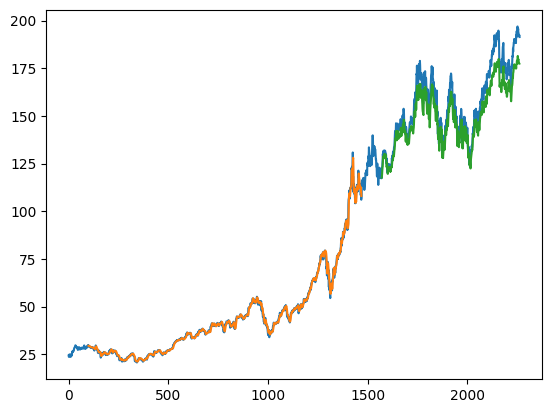

In [29]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [30]:
len(test_data)

793

In [40]:
x_input=test_data[693:].reshape(1,-1)
x_input.shape

(1, 100)

In [41]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [43]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.88755435]
101
1 day input [0.88374205 0.88407994 0.89348612 0.88216495 0.87720863 0.86273326
 0.86549321 0.87309693 0.880926   0.90283584 0.87613842 0.88869862
 0.89759782 0.91973293 0.93961523 0.94085427 0.94980982 0.95116166
 0.91291789 0.88278446 0.88627665 0.89292278 0.87568789 0.86391619
 0.87253368 0.86842198 0.8850938  0.89128949 0.87112557 0.86233892
 0.86718277 0.87444859 0.85124335 0.84262578 0.84409008 0.84701902
 0.86132523 0.85372142 0.86081826 0.86785891 0.88239029 0.89083888
 0.88745941 0.89540103 0.90052668 0.89005037 0.88931814 0.8804753
 0.87309693 0.87095658 0.8564251  0.85710089 0.85957914 0.8463995
 0.82268703 0.8301782  0.84183718 0.84454078 0.86256435 0.88284099
 0.87765907 0.89219072 0.90677856 0.912805   0.91010167 0.93395802
 0.92493424 0.93982344 0.94303799 0.9526257  0.9525129  0.96243886
 0.95787065 0.96164931 0.95409199 0.95307684 0.95651708 0.95070819
 0.95397919 0.96125453 0.95104644 0.97354931 0.96734556 0.97834312
 0.98646446 0.97219574 0.98082474 0

In [44]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [39]:
len(df1)

2264

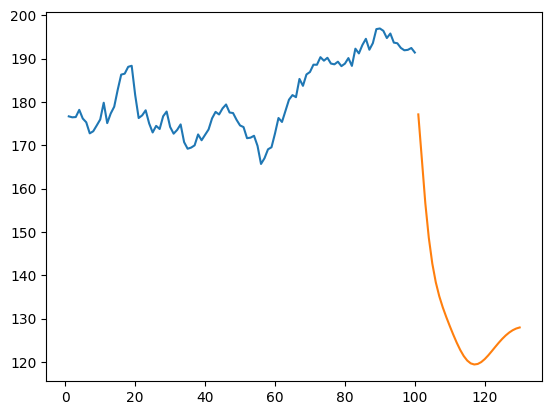

In [45]:
plt.plot(day_new,scaler.inverse_transform(df1[2164:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

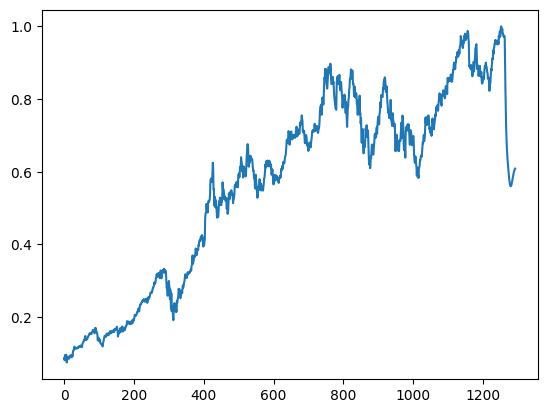

In [52]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])